In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

from functools import partial

### create Wave Data

In [2]:
train_min, train_max = 0, 10000
test_min, test_max = train_max, 12000

resolution = 0.1
n_steps = 512

def base_wave(t):
    return np.sin(t) / 3 + 0.5 * np.sin(t*5) + 0.25 * np.sin(t*10) 
    #return t * np.sin(t)  

### Train wave
def train_time_series(t):
    if t.ndim == 1:
        noise = np.random.rand(len(t))
    else:
        noise = np.random.rand(t.shape[0], t.shape[1])
    return base_wave(t) + 0.1 * noise

def train_next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (train_max - train_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = train_time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps)

### Test wave
def test_time_series_anomary(t):
    norm = (t - test_min) / (test_max - test_min)
    norm = (norm > 0.5 ) * norm 
    return np.sin(t * 20) *  (np.exp(norm) - 1)



def test_time_series(t):
    if t.ndim == 1:
        noise = np.random.rand(len(t))
    else:
        noise = np.random.rand(t.shape[0], t.shape[1]) 
    return base_wave(t) + 0.1 * noise + test_time_series_anomary(t)

def test_next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (test_max - test_min - n_steps * resolution)
    Ts = test_min + t0 + np.arange(0., n_steps + 1) * resolution
    ys = test_time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps)

### plot train data

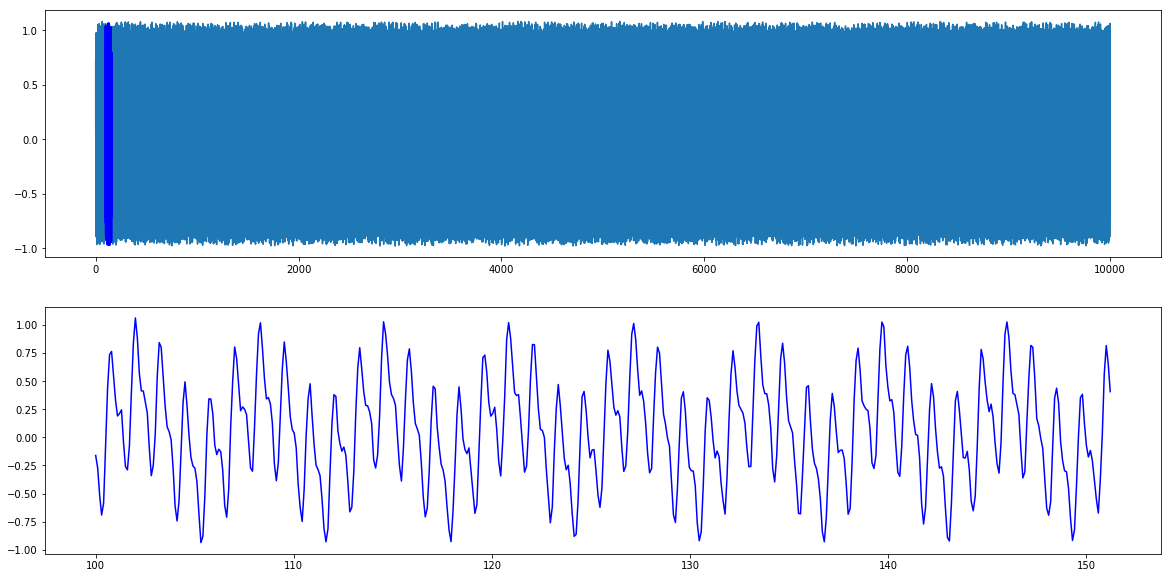

In [3]:
t = np.linspace(train_min, train_max, int((train_max - train_min) / resolution))
t_instance = np.linspace(100, 100 + resolution * (n_steps + 1), n_steps + 1)
wave_size = len(t)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(t, train_time_series(t), label=r"whole wave")
plt.plot(t_instance[:-1], train_time_series(t_instance[:-1]), "b-", linewidth=3, label="n_steps wave")
plt.subplot(212)
plt.plot(t_instance[:-1], train_time_series(t_instance[:-1]), "b-", label=r"n_steps wave")

### plot test data

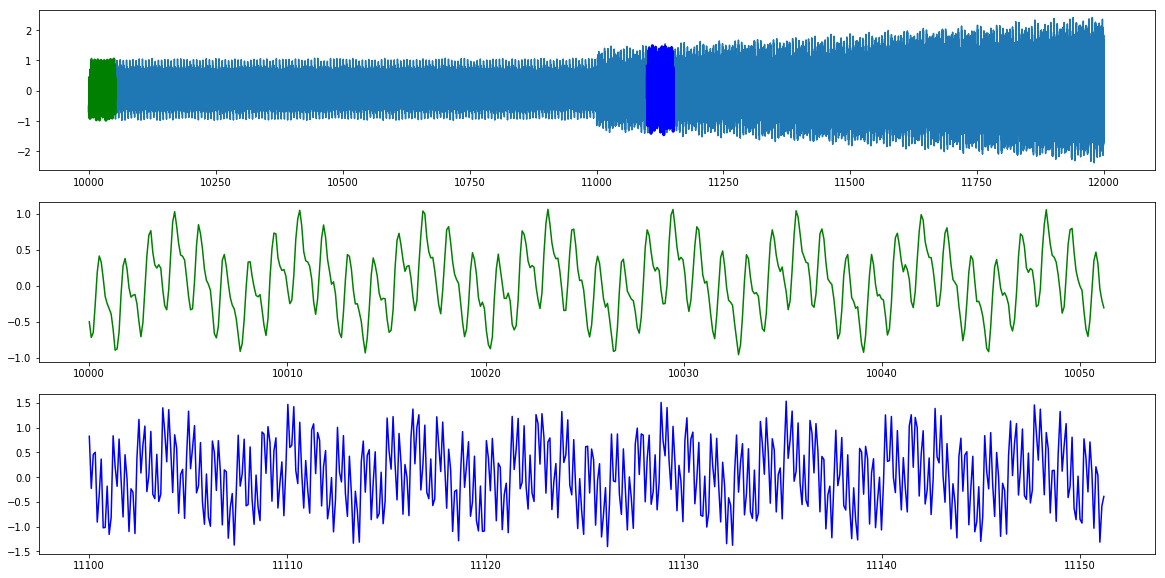

In [4]:
t = np.linspace(test_min, test_max, int((test_max - test_min) / resolution))
t_instance1 = np.linspace(test_min, test_min + resolution * (n_steps + 1), n_steps + 1)
t_instance2 = np.linspace(test_min + 1100, test_min + 1100 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(t, test_time_series(t), label=r"whole wave")
plt.plot(t_instance1[:-1], test_time_series(t_instance1[:-1]), "g-", linewidth=3, label="n_steps wave")
plt.plot(t_instance2[:-1], test_time_series(t_instance2[:-1]), "b-", linewidth=3, label="n_steps wave")
plt.subplot(312)
plt.plot(t_instance1[:-1], test_time_series(t_instance1[:-1]), "g-", label=r"n_steps wave")
plt.subplot(313)
plt.plot(t_instance2[:-1], test_time_series(t_instance2[:-1]), "b-", label=r"n_steps wave")

In [5]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()    

In [6]:
def variable_summaries(var):
    """ Attach a lot of summaries to a Tensor (for TensorBoard visualization). """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### set parameters

In [7]:
learning_rate = 0.001

training_epochs = 10
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_input = n_steps
n_hidden_1 = 64
n_hidden_2 = 32

# log directory for tensorboard
log_dir = '/tmp/tensorflow/autoencoder/logs/summaries'

In [8]:
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_input])

### 標準セットのlayerを定義する

ここでは、重みの初期化に"He"を、regularizerに"l2"を設定する。  
また、tensorboardへの表示用の出力も設定する。

In [9]:
def nn_layer(input_tensor, output_dim, name, activation=tf.nn.elu, l2_reg = 0.0005):
    with tf.variable_scope(name):
        
        he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
        l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 
        layer = tf.layers.dense(input_tensor, output_dim, 
                                activation=activation,
                                kernel_initializer=he_init,
                                kernel_regularizer=l2_regularizer)
        
        layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name)
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer

### decoder部

In [10]:
def encoder(x):
    layer_1 = nn_layer(x, n_hidden_1, name='encoder_1')
    layer_2 = nn_layer(layer_1, n_hidden_2, name='encoder_2')
    return layer_2

### encoder部

In [11]:
def decoder(x):
    layer_1 = nn_layer(x, n_hidden_1, name='decoder_1')
    layer_2 = nn_layer(layer_1, n_input, name='decoder_2', activation=None)
    return layer_2

### 二乗和誤差を用いてロス値を計算する方法

In [12]:
# Construct model
with tf.name_scope('encoder_part'):
    encoder_op = encoder(X)

with tf.name_scope('decoder_part'):
    decoder_op = decoder(encoder_op)

# Prediction
with tf.name_scope('prediction'):
    y_pred = decoder_op

# Targets (Labels) are the input data.
with tf.name_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.name_scope('reduce_mean'):
    #cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    cost = tf.reduce_mean(tf.square(y_true - y_pred))
tf.summary.scalar('reduce_mean', cost)


with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


### シグモイド＆クロスエントロピー誤差を用いてロス値を計算する方法

In [13]:
"""
# Construct model
with tf.name_scope('encoder_part'):
    encoder_op = encoder(X)

with tf.name_scope('decoder_part'):
    decoder_op = decoder(encoder_op)

# Prediction
with tf.name_scope('prediction'):
    y_pred = tf.nn.sigmoid(decoder_op)

# Targets (Labels) are the input data.
with tf.name_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.name_scope('reduce_mean'):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=decoder_op)
    cost = tf.reduce_mean(loss)
tf.summary.scalar('reduce_mean', cost)


with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
"""

"\n# Construct model\nwith tf.name_scope('encoder_part'):\n    encoder_op = encoder(X)\n\nwith tf.name_scope('decoder_part'):\n    decoder_op = decoder(encoder_op)\n\n# Prediction\nwith tf.name_scope('prediction'):\n    y_pred = tf.nn.sigmoid(decoder_op)\n\n# Targets (Labels) are the input data.\nwith tf.name_scope('target'):\n    y_true = X\n\n# Define loss and optimizer, minimize the squared error\nwith tf.name_scope('reduce_mean'):\n    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=decoder_op)\n    cost = tf.reduce_mean(loss)\ntf.summary.scalar('reduce_mean', cost)\n\n\nwith tf.name_scope('train'):\n    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)\n"

Epoch: 0001 cost= 0.006478570
Epoch: 0002 cost= 0.004145750
Epoch: 0003 cost= 0.002937509
Epoch: 0004 cost= 0.002261414
Epoch: 0005 cost= 0.001865842
Epoch: 0006 cost= 0.001561528
Epoch: 0007 cost= 0.001388983
Epoch: 0008 cost= 0.001244807
Epoch: 0009 cost= 0.001153913
Epoch: 0010 cost= 0.001073614
Optimization Finished!


/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


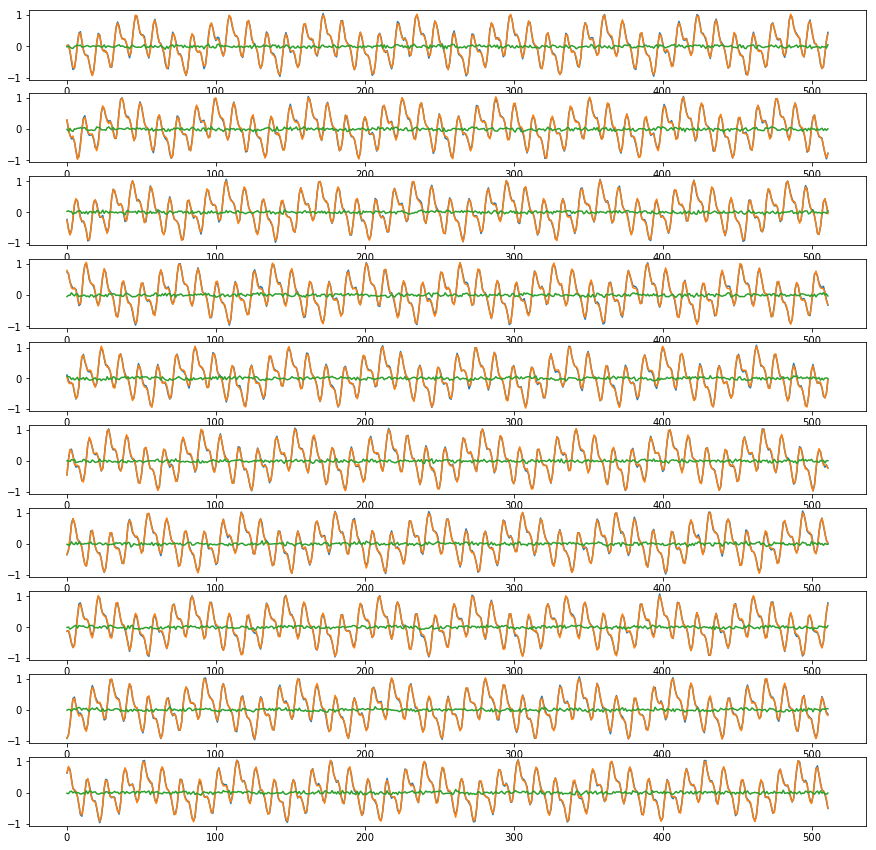

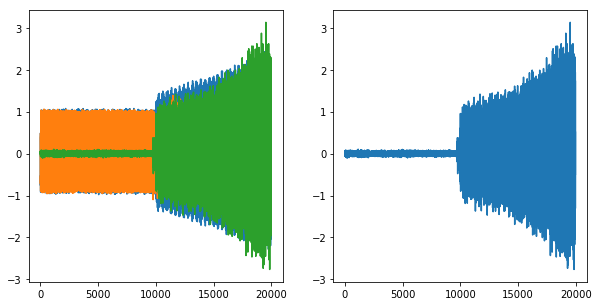

In [14]:
# Initializing the variables
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')

    total_batch = int(wave_size/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs = train_next_batch(batch_size, n_steps)
            # Run optimization op (backprop) adn cost op (to get loss value)
            summary, _, c = sess.run([merged, optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            sys.stdout.flush()
        train_writer.add_summary(summary, epoch)
    print("Optimization Finished!")
    train_writer.close()
    test_writer.close()

    # Applying encode and decode over test set
    batch_xs = batch_xs = train_next_batch(examples_to_show, n_steps)
    train_encode_decode = sess.run(y_pred,
                             feed_dict={X: batch_xs})
    # Compare original images with their reconstructions
    f, a = plt.subplots(10, 1, figsize=(15, 15))
    for i in range(examples_to_show):
        a[i].plot(batch_xs[i])
        a[i].plot(train_encode_decode[i])
        a[i].plot(batch_xs[i] - train_encode_decode[i])
    f.show()
    
    # 
    
    t = np.linspace(test_min, test_max, int((test_max - test_min) / resolution))
    n_data = int(len(t) / n_input) * n_input
    x_batch = t[:n_data].reshape(-1, n_input)
    test_encode_decode = sess.run(y_pred,
                             feed_dict={X: test_time_series(x_batch)})
    
    f, a = plt.subplots(1, 2, figsize=(10, 5))
    input_wave = test_time_series(x_batch.reshape(-1,1))
    output_wave = test_encode_decode.reshape(-1,1)
    a[0].plot(input_wave)
    a[0].plot(output_wave)
    a[0].plot(output_wave - input_wave)
    a[1].plot(output_wave - input_wave)

sess.close()